In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import torch.nn as nn
import torch
import itertools

from emnist import get_emnist_data_loaders
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
from training.trainer import Trainer
from hyperparameter import common_hyperparameters, model_specific_hyperparameters
from evaluation.loss import plot_loss, plot_multiple_losses
from evaluation.evaluations_utils import create_directory_if_not_exists
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, LambdaLR, CyclicLR

In [3]:
# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(*model_specific_hyperparameters.values()))
print(f"Number of Hyperparameter combinations: {len(param_combinations)}")

# TODO Remove in final notebook
param_combinations = param_combinations[:3]

Number of Hyperparameter combinations: 12


In [4]:
trainers = {}
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Testing parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    num_classes = common_hyperparameters["NUM_CLASSES"]   
    blank_label = common_hyperparameters["BLANK_LABEL"]
    image_height = common_hyperparameters["IMAGE_HEIGHT"]
    digits_per_sequence = common_hyperparameters["DIGITS_PER_SEQUENCE"]
    number_of_sequences = common_hyperparameters["NUMBER_OF_SEQUENCES"]
    epochs = common_hyperparameters["EPOCHS"]
    weight_decay = common_hyperparameters["WEIGHT_DECAY"]

    # Load data
    train_loader, val_loader, test_loader = get_emnist_data_loaders(number_of_sequences, digits_per_sequence, batch_size, batch_size_val)


    # Setup model
    models = {
        # "lstm_cnn": CNN_LSTM(gru_hidden_size=gru_hidden_size, gru_num_layers=gru_num_layers, num_classes=num_classes, cnn_output_height=cnn_output_height),
        "crnn": CRNN(gru_hidden_size, gru_num_layers, num_classes, cnn_output_height)
    }

    criteria = {
        "crnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True),
        "lstm_cnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True)
    }

    optimizer_configs = {
        "adam": torch.optim.Adam,
        # "adam_w": torch.optim.AdamW,
        # "adam_w_regulise": torch.optim.AdamW
    }

    scheduler_configs = {
        "step_lr": (StepLR, {"step_size": 5, "gamma": 0.5}),
        "no_scheduler": (None, None),
        # "multi_step_lr": (MultiStepLR, {"milestones": [5, 10, 15], "gamma": 0.5}),
        # "exponential_lr": (ExponentialLR, {"gamma": 0.95}),
        # "cosine_annealing_lr": (CosineAnnealingLR, {"T_max": 10}),
        # "lambda_lr": (LambdaLR, {"lr_lambda": lambda epoch: 0.95 ** epoch}),
        # "cyclic_lr": (CyclicLR, {"base_lr": 0.001, "max_lr": 0.1})
    }

    # Setup trainer
    # lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, test_loader, epochs=epochs, args={
    #         "blank_label": blank_label,
    #         "cnn_output_width": cnn_output_width,
    #     })
    # trainers = {
    #     "lstm_cnn": lstm_trainer
    # }

    for model_name, model in models.items():
        for optimizer_name, optimizer_class in optimizer_configs.items():
            if optimizer_name == "adam_w_regulise":
                optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            for scheduler_name, (scheduler_class, scheduler_args) in scheduler_configs.items():
                if scheduler_name == "no_scheduler":
                    scheduler = None
                else:
                    scheduler = scheduler_class(optimizer, **scheduler_args)
                criterion = criteria[model_name]

                # Create model name
                abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
                abbreviation = abbreviation.replace(".", "_")
                main_model_name = model_name.split('-', 1)[0]
                trainer_name = f"{model_name}-{optimizer_name}_{scheduler_name}_{abbreviation}"

                trainer = Trainer(
                    model, model_name, criterion, optimizer, train_loader, val_loader, test_loader,
                    epochs=epochs, args={"blank_label": blank_label, "cnn_output_width": cnn_output_width},
                    scheduler=scheduler
                )
                # trainer.to_device("mps")
                trainers[trainer_name] = trainer
print(f"Prepared {len(trainers)} models for training.")

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 64, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 128, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.001, 
Batch Size: 64, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.001, 
Batch Size: 128, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.0001, 
Batch Size: 64, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 

In [5]:
for key in trainers.keys():  
    print(key)

crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64
crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64
crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64


Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.53it/s]
EPOCH 1/2 - TRAINING. Loss: 9.625262260437012 - Correct: 0/700 = 0.0000 - Average CER Score: 0.91
100%|██████████| 5/5 [00:00<00:00, 10.07it/s]
EPOCH 1/2 - VALIDATING. Loss: 6.103333950042725 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
EPOCH 2/2 - TRAINING. Loss: 3.210564136505127 - Correct: 0/700 = 0.0000 - Average CER Score: 0.955
100%|██████████| 5/5 [00:00<00:00, 10.44it/s]
EPOCH 2/2 - VALIDATING. Loss: 3.1075775623321533 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 96.21it/s]
TESTING. Loss: 2.945350170135498 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


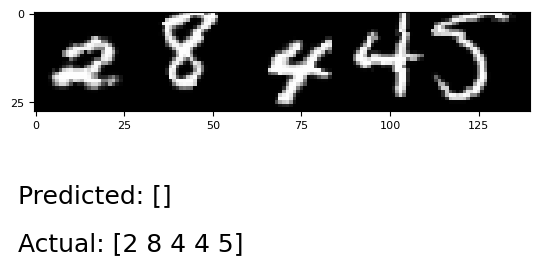

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 7.422322034835815 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.53it/s]
EPOCH 1/2 - TRAINING. Loss: 2.8011882305145264 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.26it/s]
EPOCH 1/2 - VALIDATING. Loss: 2.797633409500122 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.62it/s]
EPOCH 2/2 - TRAINING. Loss: 2.661609411239624 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 11.45it/s]
EPOCH 2/2 - VALIDATING. Loss: 2.6414105892181396 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 124.78it/s]
TESTING. Loss: 2.6750946044921875 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


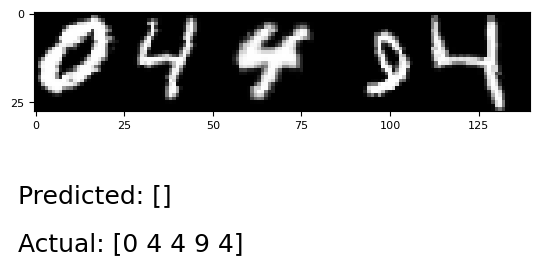

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 7.289496183395386 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 6/6 [00:02<00:00,  2.00it/s]
EPOCH 1/2 - TRAINING. Loss: 12.752561569213867 - Correct: 0/700 = 0.0000 - Average CER Score: 0.919
100%|██████████| 5/5 [00:00<00:00, 10.82it/s]
EPOCH 1/2 - VALIDATING. Loss: 10.962087631225586 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.91
100%|██████████| 6/6 [00:02<00:00,  2.02it/s]
EPOCH 2/2 - TRAINING. Loss: 3.6124420166015625 - Correct: 0/700 = 0.0000 - Average CER Score: 0.942
100%|██████████| 5/5 [00:00<00:00,  9.03it/s]
EPOCH 2/2 - VALIDATING. Loss: 3.812605381011963 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.955
100%|██████████| 1/1 [00:00<00:00, 17.35it/s]
TESTING. Loss: 4.023612976074219 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.955


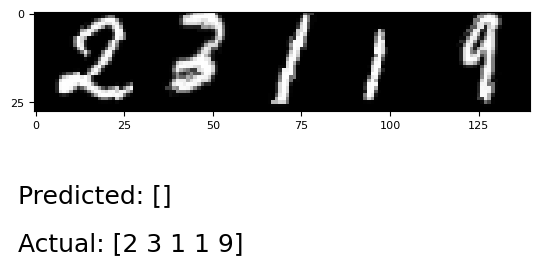

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 7.327241897583008 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 6/6 [00:03<00:00,  1.90it/s]
EPOCH 1/2 - TRAINING. Loss: 3.324082612991333 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.92it/s]
EPOCH 1/2 - VALIDATING. Loss: 3.208801507949829 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.77it/s]
EPOCH 2/2 - TRAINING. Loss: 2.801417827606201 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 11.21it/s]
EPOCH 2/2 - VALIDATING. Loss: 2.800394058227539 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 129.62it/s]
TESTING. Loss: 2.615166425704956 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


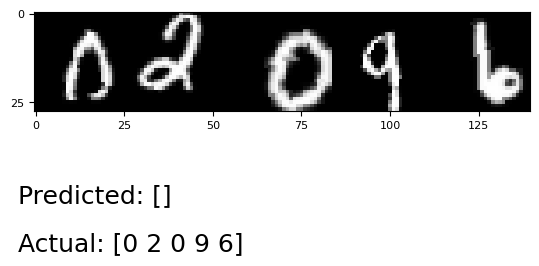

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 7.794288158416748 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.52it/s]
EPOCH 1/2 - TRAINING. Loss: 2.665182590484619 - Correct: 0/700 = 0.0000 - Average CER Score: 0.991
100%|██████████| 5/5 [00:00<00:00, 10.71it/s]
EPOCH 1/2 - VALIDATING. Loss: 2.6371195316314697 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.70it/s]
EPOCH 2/2 - TRAINING. Loss: 2.711815595626831 - Correct: 0/700 = 0.0000 - Average CER Score: 0.996
100%|██████████| 5/5 [00:00<00:00, 10.09it/s]
EPOCH 2/2 - VALIDATING. Loss: 2.6881463527679443 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 104.44it/s]
TESTING. Loss: 2.676325559616089 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


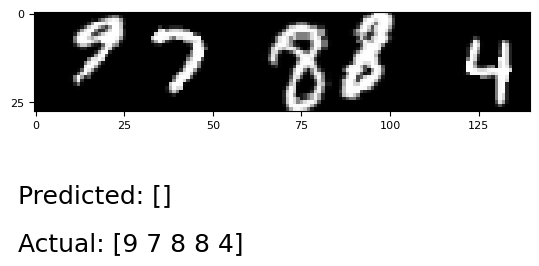

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 7.3099000453948975 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.33it/s]
EPOCH 1/2 - TRAINING. Loss: 2.603881359100342 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 11.33it/s]
EPOCH 1/2 - VALIDATING. Loss: 2.588735818862915 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.63it/s]
EPOCH 2/2 - TRAINING. Loss: 2.5636041164398193 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.28it/s]
EPOCH 2/2 - VALIDATING. Loss: 2.5564568042755127 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 116.29it/s]
TESTING. Loss: 2.5220091342926025 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


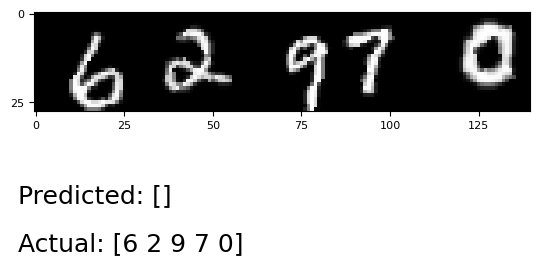

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 7.507489919662476 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64
100%|██████████| 6/6 [00:02<00:00,  2.01it/s]
EPOCH 1/2 - TRAINING. Loss: 3.270272731781006 - Correct: 0/700 = 0.0000 - Average CER Score: 0.983
100%|██████████| 5/5 [00:00<00:00, 10.64it/s]
EPOCH 1/2 - VALIDATING. Loss: 3.3408408164978027 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
EPOCH 2/2 - TRAINING. Loss: 2.7544801235198975 - Correct: 0/700 = 0.0000 - Average CER Score: 0.991
100%|██████████| 5/5 [00:00<00:00,  9.96it/s]
EPOCH 2/2 - VALIDATING. Loss: 2.908111810684204 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 121.61it/s]
TESTING. Loss: 3.1277709007263184 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


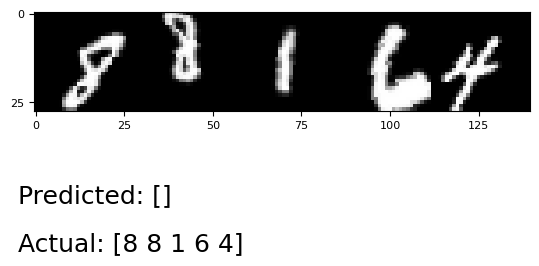

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 7.37493109703064 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64
100%|██████████| 6/6 [00:03<00:00,  1.89it/s]
EPOCH 1/2 - TRAINING. Loss: 2.663745403289795 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.07it/s]
EPOCH 1/2 - VALIDATING. Loss: 2.6935930252075195 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.91it/s]
EPOCH 2/2 - TRAINING. Loss: 2.6248347759246826 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.31it/s]
EPOCH 2/2 - VALIDATING. Loss: 2.616346597671509 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 100.20it/s]
TESTING. Loss: 2.4612812995910645 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


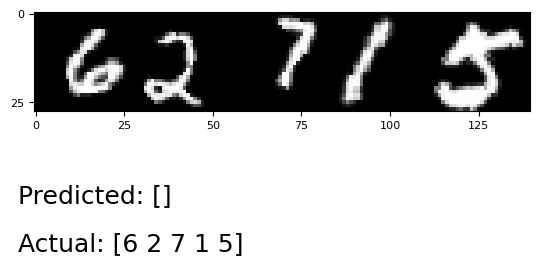

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64 and took 7.642039060592651 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.54it/s]
EPOCH 1/2 - TRAINING. Loss: 6.742012023925781 - Correct: 0/700 = 0.0000 - Average CER Score: 0.983
100%|██████████| 5/5 [00:00<00:00, 10.08it/s]
EPOCH 1/2 - VALIDATING. Loss: 6.267922878265381 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
EPOCH 2/2 - TRAINING. Loss: 3.1862404346466064 - Correct: 0/700 = 0.0000 - Average CER Score: 0.991
100%|██████████| 5/5 [00:00<00:00, 10.27it/s]
EPOCH 2/2 - VALIDATING. Loss: 3.0477380752563477 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 122.64it/s]
TESTING. Loss: 3.189631938934326 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


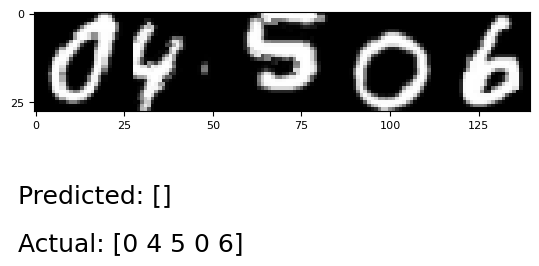

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 7.531768083572388 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.52it/s]
EPOCH 1/2 - TRAINING. Loss: 2.642423152923584 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00,  9.78it/s]
EPOCH 1/2 - VALIDATING. Loss: 2.620356798171997 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
EPOCH 2/2 - TRAINING. Loss: 2.7037546634674072 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.65it/s]
EPOCH 2/2 - VALIDATING. Loss: 2.67140793800354 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 124.46it/s]
TESTING. Loss: 2.7389066219329834 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


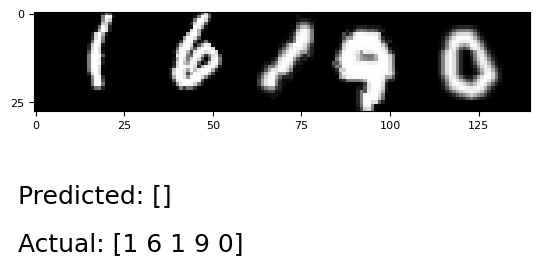

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64 and took 7.179502010345459 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64
100%|██████████| 6/6 [00:02<00:00,  2.06it/s]
EPOCH 1/2 - TRAINING. Loss: 10.133691787719727 - Correct: 0/700 = 0.0000 - Average CER Score: 0.909
100%|██████████| 5/5 [00:00<00:00, 10.10it/s]
EPOCH 1/2 - VALIDATING. Loss: 9.668145179748535 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.901
100%|██████████| 6/6 [00:03<00:00,  1.99it/s]
EPOCH 2/2 - TRAINING. Loss: 7.524241924285889 - Correct: 0/700 = 0.0000 - Average CER Score: 0.936
100%|██████████| 5/5 [00:00<00:00, 11.27it/s]
EPOCH 2/2 - VALIDATING. Loss: 7.121280193328857 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.951
100%|██████████| 1/1 [00:00<00:00, 92.57it/s]
TESTING. Loss: 7.001992225646973 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.951


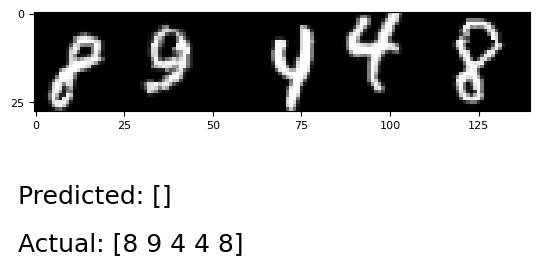

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 7.172526836395264 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64
100%|██████████| 6/6 [00:02<00:00,  2.08it/s]
EPOCH 1/2 - TRAINING. Loss: 5.038473129272461 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.90it/s]
EPOCH 1/2 - VALIDATING. Loss: 4.663031101226807 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.92it/s]
EPOCH 2/2 - TRAINING. Loss: 3.3325741291046143 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.35it/s]
EPOCH 2/2 - VALIDATING. Loss: 3.169534683227539 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 1/1 [00:00<00:00, 99.05it/s]
TESTING. Loss: 3.215393543243408 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


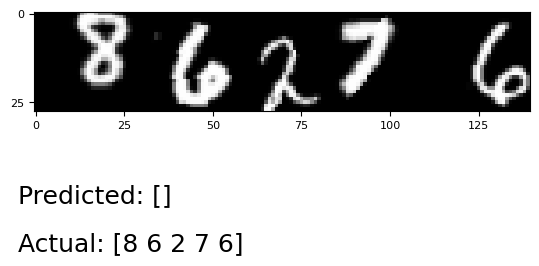

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_0001__BS128__BSV64 and took 7.268538951873779 seconds.


In [6]:
import time

metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    start_time = time.time()
    metrics = trainer.train_validate_test()
    end_time = time.time()
    print(f"Finished training {model_name} and took {end_time - start_time} seconds.")
    # Save the trained model with abbreviation and parameter values
    main_model_name = model_name.split('-', 1)[0]
    base_path = f'models/{main_model_name}/{model_name}/'

    # Add metrics to model name
    metrics_global[f"{model_name}"] = metrics
    
    # Save model to disk
    create_directory_if_not_exists(base_path)
    save_path = base_path + "model.pth"
    torch.save(trainer.model.state_dict(), save_path)

In [7]:
from utils import get_dict_from_pkl, save_dict_to_pkl
# Save and load metrics to file
save_dict_to_pkl(metrics_global, "metrics_global")
grid_search_metrics = get_dict_from_pkl("metrics_global")

In [45]:
# Get top 5 models based on loss
top_models = {}

for model_name, model_scores_top_5 in grid_search_metrics.items():
    model_loss = model_scores_top_5["test_loss"][0]
    top_models[model_name] = model_loss

# Sort models by loss (ascending order)
sorted_models = dict(sorted(top_models.items(), key=lambda item: item[1]))

# Get top 5 models
top_5_models = dict(list(sorted_models.items())[:5])

# Create a new dictionary with numerical keys
numerical_top_models = {model: {"id": idx, "loss": loss} for idx, (model, loss) in enumerate(top_5_models.items())}

# Print the top 5 models with numerical keys
for item in numerical_top_models.items():
    print(item)


('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64', {'id': 0, 'loss': 2.4612812995910645})
('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 1, 'loss': 2.5220091342926025})
('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64', {'id': 2, 'loss': 2.615166425704956})
('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64', {'id': 3, 'loss': 2.6750946044921875})
('crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 4, 'loss': 2.676325559616089})


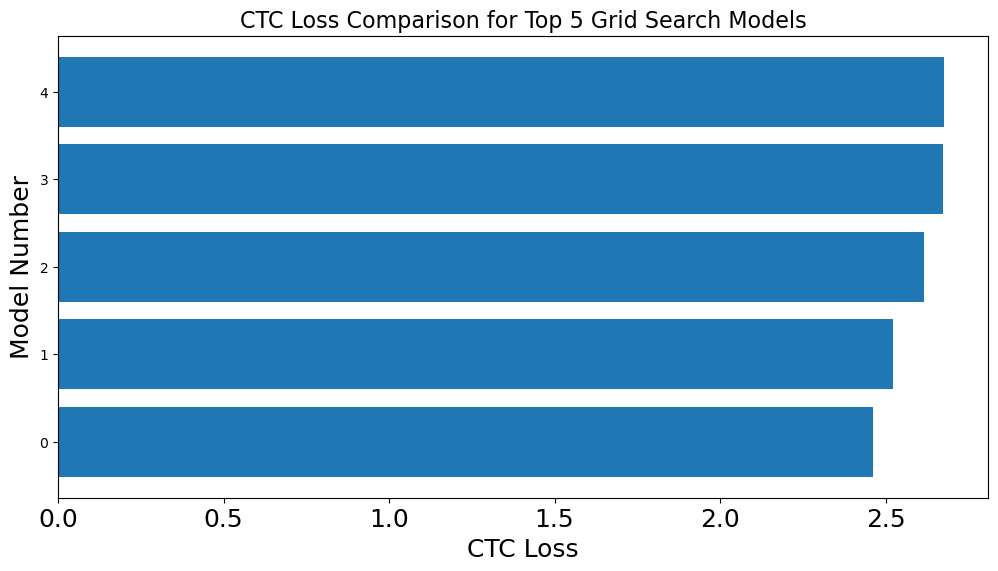

In [46]:
import numpy as np
from utils import split_and_insert_newline_list 
import matplotlib.pyplot as plt

model_names_top_5 = list(numerical_top_models.keys())
model_number_top_5 = [item["id"] for idx, item in numerical_top_models.items()]
model_scores_top_5 = [item["loss"] for idx, item in numerical_top_models.items()]

# Create a horizontal bar plot for all metrics
# Update fig size
plt.figure(figsize=(12, 6), dpi=100)

plt.barh(model_number_top_5, model_scores_top_5)  # Horizontal bar plot

plt.xlabel('CTC Loss')  # Adjust label
plt.ylabel('Model Number')  # Adjust label
plt.title('CTC Loss Comparison for Top 5 Grid Search Models', fontsize=16)  # Adjust title font size

# Customize font size for model names
plt.yticks(fontsize=10)

plt.show()


In [47]:
for model_name, trainer in trainers.items():
    main_model_name = model_name.split('-', 1)[0]
    # Get model paths
    base_path = f'models/{main_model_name}/{model_name}/'
    model_path = base_path + "model.pth"
    
    print(f"Saving Loss Plot for model: {model_name}")
    #model = model.to("mps")
    model.load_state_dict(torch.load(model_path))

    # Plot the trained model
    plot_loss(model_name=model_name, train_loss_per_epoch=trainer.metrics["train_loss"], val_loss_per_epoch=trainer.metrics["val_loss"], figure_evaluation_dir=base_path)

Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS128__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS128__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS64__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_0001__BS64__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_0001__BS128__BSV64
Saving Loss Plot for mode

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [50]:
#TODO Plot training and val for each model

model_ids = []
model_training_losses = []
model_val_losses = []

for model_name, trainer in trainers.items():
    if model_name in model_names_top_5:
        model_id = numerical_top_models[model_name]["id"]
        model_ids.append(model_id)
        model_training_losses.append(trainer.metrics["train_loss"])
        model_val_losses.append(trainer.metrics["val_loss"])

# Get model paths
main_model_name = model_name.split('-', 1)[0]
base_path = f'models/{main_model_name}/'

# Plot the trained model
plot_multiple_losses(
    model_names=model_ids, 
    train_losses_list=model_training_losses, 
    val_losses_list=model_val_losses, 
    figure_evaluation_dir=base_path
)

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 134.58it/s]
TESTING. Loss: 2.8057124614715576 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.964


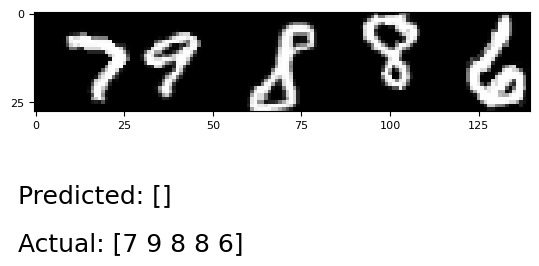

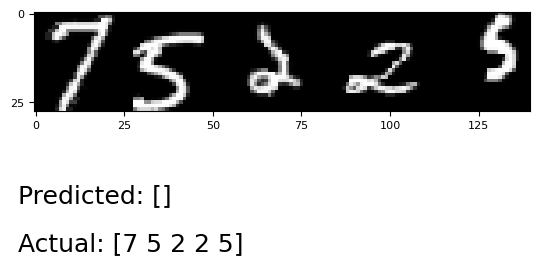

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 81.65it/s]
TESTING. Loss: 2.8057124614715576 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


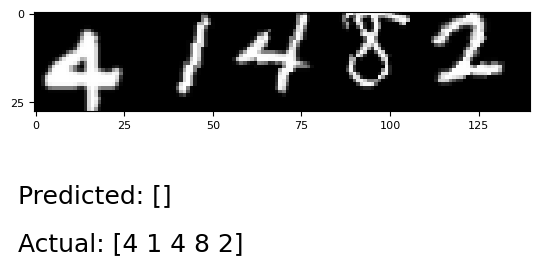

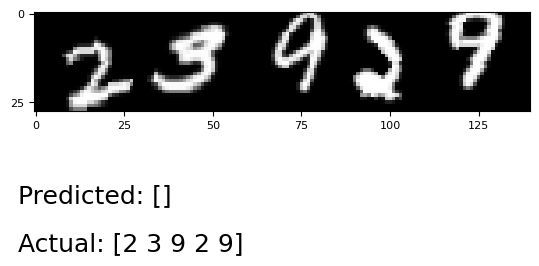

In [11]:
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    for model_name, trainer in trainers.items():
        print(f"Testing model {model_name}")

        # Plot the trained model
        trainer.test(plot_n=2)